In [1]:
import pandas as pd
import numpy as np
from pandas import json_normalize
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool
)
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.models.sources import ColumnDataSource
from bokeh.sampledata.sample_geojson import geojson

# notebook inspired by @rameerez

In [3]:
_path = './data/202105.json'

_df = pd.read_json(_path, lines=True)
display(_df.head())

,_id,stations
0,2021-05-01T00:23:14.845494,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
1,2021-05-01T01:23:20.563888,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
2,2021-05-01T02:23:20.606340,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
3,2021-05-01T03:23:21.653407,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
4,2021-05-01T04:23:21.823719,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."


In [4]:
frames = []

for index, row in _df.iterrows():
    timestamp= row['_id']
    stations = json_normalize(row['stations'])
    stations['timestamp'] = timestamp
    frames.append(stations)

In [5]:
df_stations = pd.concat(frames)

In [6]:
station1 = df_stations.loc[df_stations['id'] == 174]
station2 = df_stations.loc[df_stations['id'] == 101]
station3 = df_stations.loc[df_stations['id'] == 3]

In [7]:
def datetime(x):
    return np.array(x, dtype=np.datetime64)

In [8]:
p1 = figure(x_axis_type="datetime", title="Station free bases")
p1.grid.grid_line_alpha=0.3
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = '# of free bases'

p1.line(datetime(station1['timestamp'].values), station1['free_bases'].values, color='#A6CEE3', legend_label=station1['name'].iloc[0])
p1.legend.location = "top_left"

aapl = np.array(station1['free_bases'].values)
aapl_dates = np.array(station1['timestamp'].values, dtype=np.datetime64)

window_size = 30
window = np.ones(window_size)/float(window_size)
aapl_avg = np.convolve(aapl, window, 'same')

p2 = figure(x_axis_type="datetime", title="Station free bases (average)")
p2.grid.grid_line_alpha = 0
p2.xaxis.axis_label = 'Date'
p2.yaxis.axis_label = '# of free bases'
p2.ygrid.band_fill_color = "olive"
p2.ygrid.band_fill_alpha = 0.1

p2.circle(aapl_dates, aapl, size=4, legend_label='close',
          color='darkgrey', alpha=0.2)

p2.line(aapl_dates, aapl_avg, legend_label='avg', color='navy')
p2.legend.location = "top_left"

In [9]:
output_notebook()
output_file("stocks.html", title="stocks.py example")
show(gridplot([[p1,p2]], plot_width=400, plot_height=400))  # open a browser

Loading BokehJS ...

Start : Este comando no se puede ejecutar debido al error: El sistema no puede encontrar el archivo especificado.


In [10]:
bikes_pathFile = './data/202105_movements.json'

df = pd.read_json(bikes_pathFile, lines=True)

In [11]:
df.count()

_id                 414249
user_day_code       414249
idplug_base         414249
user_type           414249
idunplug_base       414249
travel_time         414249
idunplug_station    414249
ageRange            414249
idplug_station      414249
unplug_hourTime     414249
zip_code            414249
dtype: int64

In [12]:
# sec to min
df['travel_time_mins'] = df['travel_time']/60
df['travel_time_mins'].describe()

count    414249.000000
mean         22.620252
std         426.289053
min           0.000000
25%           8.166667
50%          12.500000
75%          18.533333
max       39354.783333
Name: travel_time_mins, dtype: float64

<AxesSubplot:>

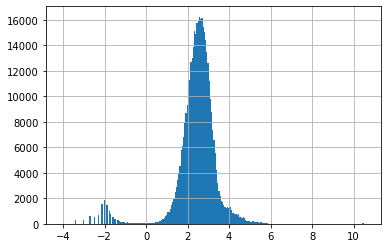

In [13]:
#We need to get rid of zero values first, to avoid divide by zero errors
df_aux = df.loc[df['travel_time_mins'] > 0]

df['travel_time_mins_log'] = np.log(df_aux['travel_time_mins'])
df['travel_time_mins_log'].hist(bins=250)

<AxesSubplot:>

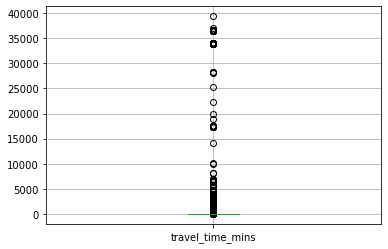

In [14]:
df_extremes = df.loc[df['travel_time_mins'] > 0]
df_extremes.boxplot(column='travel_time_mins')
# More than 5.000 min means that the bike were used more than 83 hours (more than 3 days)

In [17]:
df_extremes = df.loc[df['travel_time_mins'] > 5000]
df_extremes.travel_time_mins.count()

88

In [19]:
# Let's assume that, everything above 6h are super-outliers (360 min)

df_extremes = df.loc[df['travel_time_mins'] < 360]
df_extremes.travel_time_mins.count()

414042

403517
              label  lower_whisker  lower_quartile  median  upper_quartile  \
0  travel_time_mins            0.0            8.05   12.25            17.9   

   upper_whisker  
0      32.666667  


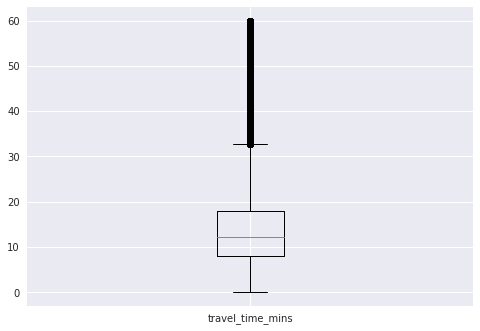

In [32]:
# And around an hour?

df_extremes = df.loc[df['travel_time_mins'] <= 60]
print(df_extremes.travel_time_mins.count())

def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

label = ['travel_time_mins']
bp = plt.boxplot(list(df_extremes.travel_time_mins), labels=label)
print(get_box_plot_data(labels, bp))
plt.show()

In [40]:
df_extremes = df.loc[df['travel_time_mins'] > 32]

pct_outlier = (df_extremes['travel_time_mins'].count() / df['travel_time_mins'].count())*100
print(f"{round(pct_outlier)}% of data are outliers")

28070
414249
7% of data are outliers


In [45]:
# Sometimes people return the bike right away because of a hidden flaw in the bike. 
# Let's say that people that return the bike in under 3 min, it's because of a defective bike

n_badBikes = df.loc[df['travel_time'] < 180]['_id'].count()

# Another indicator is if the bike is returned to the same station:
df_sameStation = df.loc[(df['idunplug_station'] == df['idplug_station'])]
n_badBikes_st = df_sameStation.loc[df_sameStation['travel_time'] < 180]['_id'].count()

print(f"From our first assumption, {n_badBikes} bikes are registered. Combining it with our second statement, {n_badBikes_st} resulted")
print(f"We can say that the difference of those results ({n_badBikes-n_badBikes_st}) are really fast travellers")

pct_badBikes = n_badBikes_st / df['travel_time'].count()

print(f"The number of defectuose bikes are {n_badBikes_st}, this value represent the {round(pct_badBikes*100)}% of all bikes")

From our first assumption, 17842 bikes are registered. Combining it with our second statement, 13121 resulted
We can say that the difference of those results (4721) are really fast travellers
The number of defectuose bikes are 13121, this value represent the 3% of all bikes


In [ ]:
# From the docs, we determine that:

# user_type = 0: undetermined
# user_type = 1: annual pass holder
# user_type = 2: occasional user 
# user_type = 3: BiciMad employee

# ageRange = 0: undetermined
# ageRange = 1: from 0 to 16 years old
# ageRange = 2: from 17 to 18 years old
# ageRange = 3: from 19 to 26 years old
# ageRange = 4: from 27 to 40 years old
# ageRange = 5: from 41 to 65 years old
# ageRange = 6: older than 66

,count,mean,std,min,25%,50%,75%,max
user_type,,,,,,,,
1,388640.0,16.336077,18.677494,0.016667,8.500000,12.633333,18.400000,359.933333
2,2223.0,41.294377,44.794094,1.633333,14.425000,24.833333,51.483333,339.216667
3,19182.0,145.219849,1975.115825,0.000000,0.133333,0.200000,14.312500,39354.783333
6,4203.0,34.296903,39.057521,1.716667,12.183333,20.300000,40.741667,352.816667
7,1.0,9.300000,NaN,9.300000,9.300000,9.300000,9.300000,9.300000


<AxesSubplot:xlabel='ageRange'>

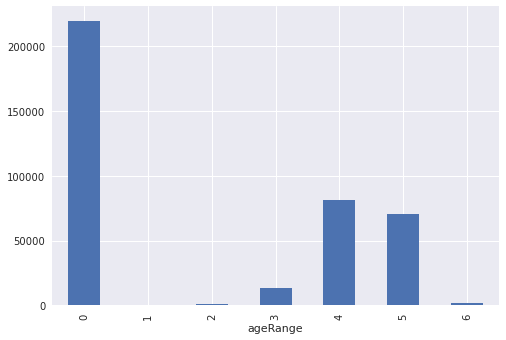

In [46]:
display(df.groupby(['user_type'])['travel_time_mins'].describe())
display(df.loc[df['user_type']==1].groupby(['ageRange'])['_id'].count().plot(kind='bar'))

In [59]:
import datetime
#df.unplug_hourTime[0].split("T")[1].split("Z")[0]
#date_time_str = df.unplug_hourTime[0]
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%dT%H:%M:%SZ')
date_time_obj.time()

df['unplugHour'] = df['unplug_hourTime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').time())
df['unplugHour'].describe()

count       414249
unique          24
top       17:00:00
freq         34447
Name: unplugHour, dtype: object

<AxesSubplot:xlabel='unplugHour'>

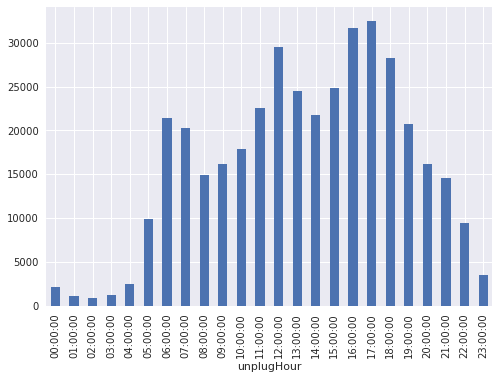

In [60]:
# Most common hour to get the bike
df.loc[df['user_type']==1].groupby(['unplugHour'])['_id'].count().plot(kind='bar')

In [136]:
# Most common hour to get the bike per station
bk = df[['user_type','_id','unplugHour','idunplug_station']]
st = df_stations[['id','name']].drop_duplicates()

result = pd.merge(st, bk, left_on = 'id', right_on = 'idunplug_station', how = 'left')
st_time = pd.DataFrame({'count' : result.loc[df['user_type']==1].groupby(['name','unplugHour'])['_id'].count()}).reset_index()

df_stTime = st_time.iloc[st_time.groupby(['name'])['count'].idxmax()]
df_stTime['unplugHour'] = df_stTime['unplugHour'].apply(lambda x: x.strftime("%H"))
display(df_stTime.head(10))

/tmp/ipykernel_4479/160620837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stTime['unplugHour'] = df_stTime['unplugHour'].apply(lambda x: x.strftime("%H"))


,name,unplugHour,count
12,Agustín de Betancourt,12,135
38,Alberto Alcocer,16,78
57,Alcalá,12,111
84,Alcalá-Ventas,15,108
109,Alcántara,16,83
130,Almadén,13,137
158,Alonso Martínez,17,270
181,Altamirano,16,138
206,Antonio López,17,124
222,Antonio Maura,12,154


<AxesSubplot:xlabel='name', ylabel='unplugHour'>

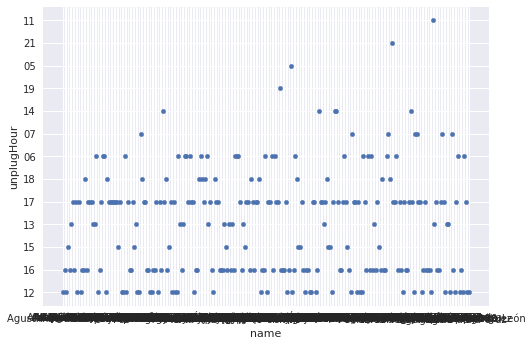

In [137]:
df_stTime.plot.scatter(x='name',y='unplugHour')